In [1]:
from dstaster import *

In [2]:
# Load data
collection = pd.read_csv("tate/paintings.csv", index_col=0)
collection = collection.join(pd.read_csv('tate/ratio_model.csv', index_col=0))
collection = collection.join(pd.read_csv('tate/title_model.csv', index_col=0))
collection['ratio'] = collection['width'] / collection['height']

collection

,artist,title,year,groundtruth,height,width,ratio_model,title_model,ratio
T13896,John Constable,Salisbury Cathedral from the Meadows,1831,L,1537,1920,L,O,1.249187
T05010,Pablo Picasso,Weeping Woman,1937,O,608,500,O,P,0.822368
N05915,Pablo Picasso,Bust of a Woman,1909,P,727,600,O,P,0.825309
N00530,Joseph Mallord William Turner,Snow Storm - Steam-Boat off a Harbour’s Mouth,1842,L,914,1219,L,L,1.333698
T00598,Richard Dadd,The Fairy Feller’s Master-Stroke,1855,O,540,394,P,O,0.729630
...,...,...,...,...,...,...,...,...,...
N05609,Maurice Sterne,Mexican Church Interior,1934,O,1283,1022,P,L,0.796571
T14823,Unknown artist,Leon Trotsky,1980,P,510,480,O,O,0.941176
AL00397,Louise Bourgeois,Untitled,1946,O,660,1116,L,O,1.690909
T14824,Unknown artist,Leon Trotsky,1980,P,638,511,O,O,0.800940


In [3]:
port_words = {'portrait', 'nude', 'bust', 'self-portrait', 'figure',
                'gentleman', 'mr', 'lord', 'count', 'sir', 'man', 'boy', 
                'dr', 'colonel',
                'mrs', 'miss', 'lady', 'dame', 'countess', 'duchess', 'woman', 'women', 'girl', 
                'husband', 'wife', 'father', 'mother', 'son', 'daughter', 'family',
                'brother', 'sister', 'child'}
land_words = {'view', 'landscape', 'house', 'church', 'mill',
              'church', 'cathedral', 'castle', 
              'bridge', 'river', 'lake', 'canal', 'channel', 'pier', 'harbour', 'thames',
              'boat', 'ship', 'beach', 'sea', 'bay', 'coast', 'cliff',
              'tree', 'flower', 'forest', 'wood', 'garden', 'park', 'meadow', 'field', 'farm',
              'mountain', 'hill', 
              'morning', 'evening', 'sunset', 'sunrise',
              'winter', 'summer', 'autumn', 'spring'}

L 105
P 96
O 122
           ratio  cport  cland
N05064  1.950440      0      0
N01273  5.000000      0      2
L01903  8.504235      0      0
N00476  5.668035      0      1
N01279  3.055556      0      0
...          ...    ...    ...
N04910  3.283984      1      0
N05505  5.365532      0      1
T14412  3.267470      0      0
T15085  2.830333      0      0
N05609  3.186282      0      1

[323 rows x 3 columns]
euclidean
manhattan
chebyshev
hamming
canberra
braycurtis


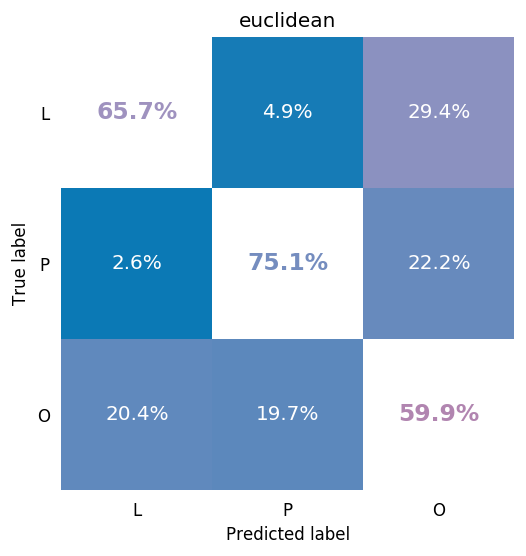

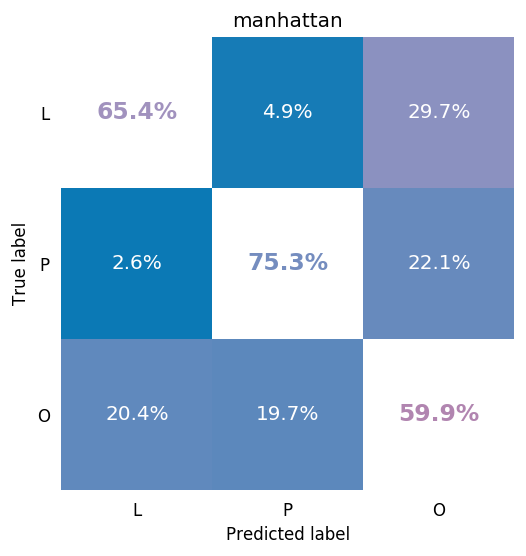

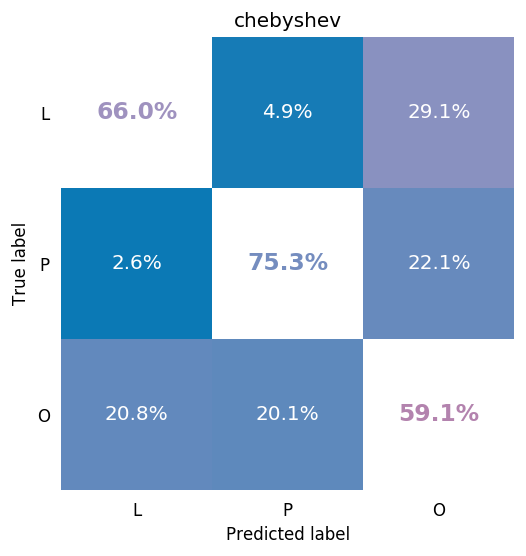

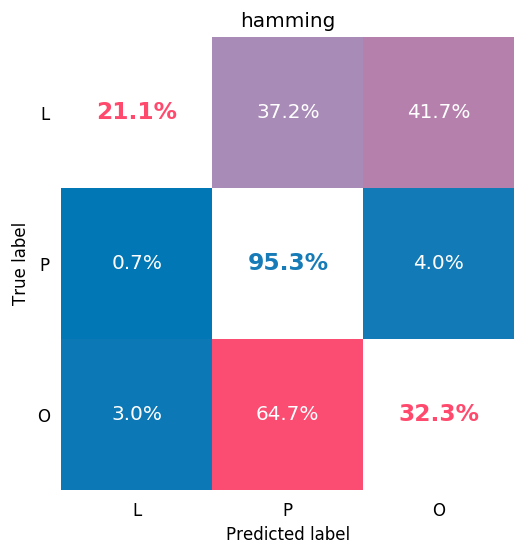

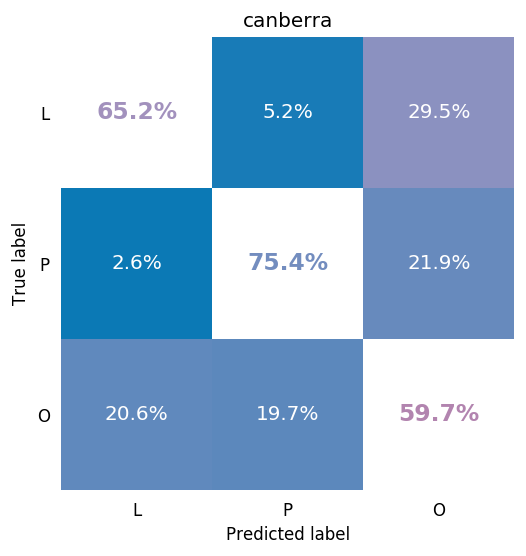

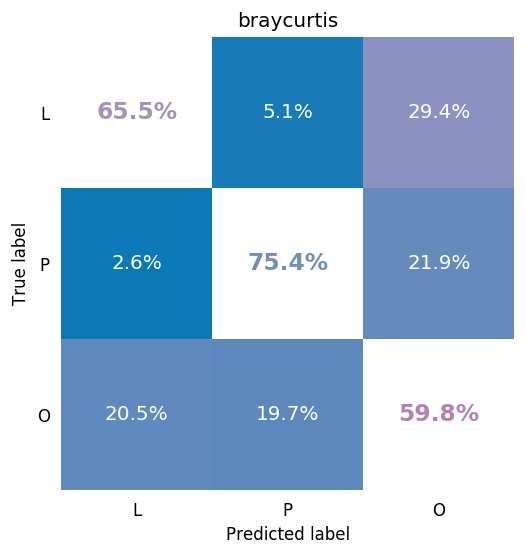

In [22]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

# Sample data
n = len(collection)
k = int(.15*n)

sample = np.zeros(n, dtype=int)
sample[:k] = 1

np.random.shuffle(sample)
sample = sample == 1

for l in 'LPO':
    print(l, sum(collection.loc[sample, 'groundtruth'] == l))
    
    
# def knn_classifier():
D = pd.DataFrame(index=collection.index)

# Include information from title classifier
titles = collection['title'].str.lower()
cport = titles.str.count('|'.join(port_words))
cland = titles.str.count('|'.join(land_words)) 

ratio = collection['ratio']
D['ratio'] = 4*ratio
D['cport'] = cport
D['cland'] = cland

# Create sample/label matrix
X = D[sample]
print(X)
y = collection['groundtruth'][sample]
    
metrics = [
'euclidean',
'manhattan',
'chebyshev',
'hamming',
'canberra',
'braycurtis'
]

for m in metrics:
    print(m)
#     classf = RadiusNeighborsClassifier(radius=20, weights='distance', metric=m).fit(X,y)
    classf = KNeighborsClassifier(3, weights='distance', metric=m).fit(X,y)
    pred = classf.predict(D)

    collection['knn_model'] = pred

    fig, ax = plt.subplots(figsize=(5,5,), dpi=120)
    plot_confusion_matrix(collection['groundtruth'], collection['knn_model'], 'LPO', ax)
    ax.set_title(m)

In [8]:
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment as lsa

np.random.seed(555) 

D = pd.DataFrame(index=collection.index)

# Include information from title classifier
titles = collection['title'].str.lower()
cport = titles.str.count('|'.join(port_words))
cland = titles.str.count('|'.join(land_words)) 

ratio = collection['ratio']
D['ratio'] = 2*ratio
D['cport'] = cport
D['cland'] = cland

clus = KMeans(n_clusters=3).fit(D)

# Slight cheating here: map clusters according to ground truth
# via maximum matching
T = collection['groundtruth']
pred = np.array(['O']*len(T))

C = np.zeros(shape=(3,3)) # Cost matrix
labeltoindex = dict(zip('PLO',[0,1,2]))
indextolabel = dict([(v,k) for k,v in labeltoindex.items()])
for c in range(3):
    indices = clus.labels_ == c
    labels = T[indices].value_counts()
    for l, count in labels.items():
        C[c,labeltoindex[l]] = count

assignment = lsa(C, maximize=True)

for c, l in zip(*assignment):
    indices = clus.labels_ == c
    pred[indices] = indextolabel[l]
collection['kmeans_model'] = pred

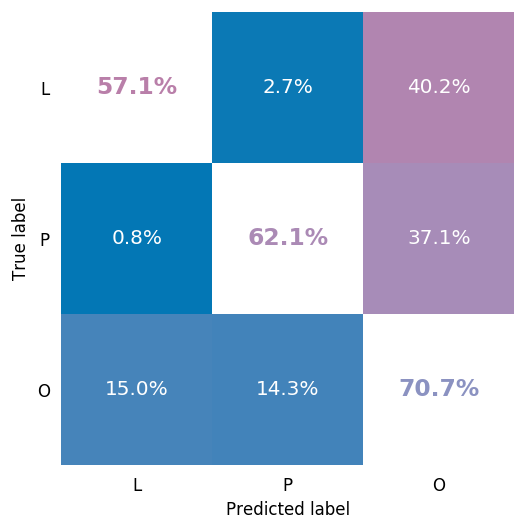

In [9]:
fig, ax = plt.subplots(figsize=(5,5,), dpi=120)
plot_confusion_matrix(collection['groundtruth'], collection['kmeans_model'], 'LPO', ax)

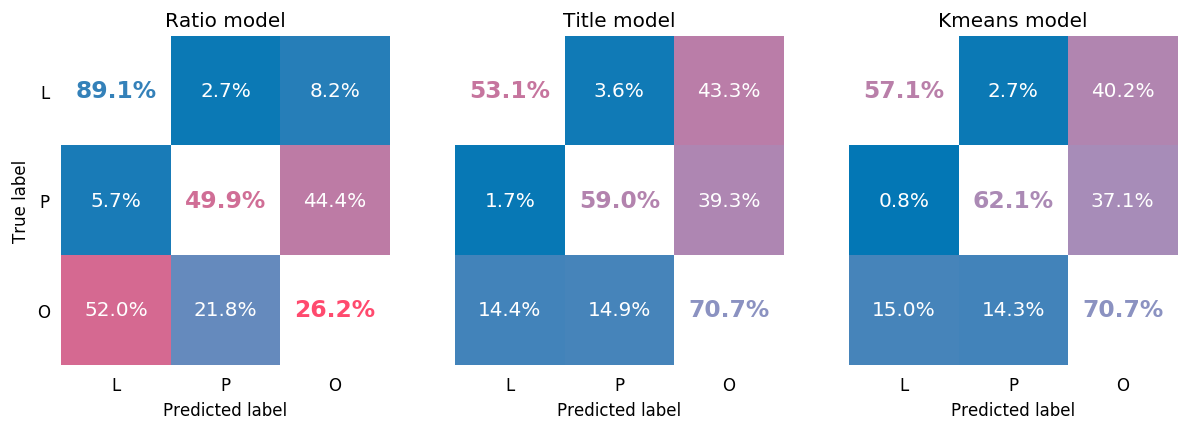

In [10]:
truth = collection['groundtruth']

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True, dpi=120)
axes = axes.ravel()

I = np.eye(3,3)
for model, ax, ylabel in zip(['ratio_model', 'title_model', 'kmeans_model'], axes, [True, False, False]):
    pred = collection[model]
    plot_confusion_matrix(truth, pred, 'LPO', ax)
    ax.set_ylabel('')
    ax.set_title(model.replace("_", " ").capitalize())

axes[0].set_ylabel('True label'); 
# cbar = axes[2].collections[0].colorbar
# cbar.set_ticks([0, .25, .5, .75, 1])
# cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

<h2>3D plot of vectors used above</h2>

In [ ]:
plt.close(fig)

In [ ]:
# %matplotlib gtk3
from mpl_toolkits.mplot3d import Axes3D 

titles = collection['title'].str.lower()
cport = titles.str.count('|'.join(port_words))
cland = titles.str.count('|'.join(land_words)) 

ratio = collection['ratio']
zs = ratio
xs = cport  + np.random.normal(0, .05, cport.shape)
ys = cland  + np.random.normal(0, .05, cport.shape)

# Plot groundtruth
fig = plt.figure(figsize=(10,10), dpi=200)
ax = fig.add_subplot(111, projection='3d')

irest = collection['groundtruth'] == 'O'
iland = collection['groundtruth'] == 'L'
iport = collection['groundtruth'] == 'P'

for index, name, col in zip([irest,iland,iport],['Other','Landscape','Portrait'],['lightgray','green','blue']):
    ax.scatter(xs[index], ys[index], zs[index], marker='+', color=colors[col], alpha=.5)

ax.set_zlabel('Ratio')
ax.set_xlabel('# of portrait words')
ax.set_ylabel('# of landscape words')
ax.set_zlim(.8, 3)

ax.azim = 67
ax.elev = 30

plt.show()

# Plot clusters
fig = plt.figure(figsize=(10,10), dpi=200)
ax = fig.add_subplot(111, projection='3d')

irest = collection['kmeans_model'] == 'O'
iland = collection['kmeans_model'] == 'L'
iport = collection['kmeans_model'] == 'P'

for index, name, col in zip([irest,iland,iport],['Other','Landscape','Portrait'],['lightgray','green','blue']):
    ax.scatter(xs[index], ys[index], zs[index], marker='+', color=colors[col], alpha=.5)

ax.set_zlabel('Ratio')
ax.set_xlabel('# of portrait words')
ax.set_ylabel('# of landscape words')
ax.set_zlim(.8, 3)

ax.azim = 67
ax.elev = 45

plt.show()

In [ ]:
collection['mixed'] = 'O'
collection.loc[(collection['title_model'] == 'P') & (collection['ratio_model'] == 'P'), 'mixed'] = 'P'
collection.loc[collection['ratio_model'] == 'L', 'mixed']  = 'L'